In [1]:
import jax.experimental.ode as ode
import jax
import diffrax
import ticktack


In [2]:
parameters = (774.86, 0.25, 0.8, 6.44)
model = ticktack.load_presaved_model(
    "Guttler15", production_rate_units="atoms/cm^2/s")
model.compile()

STEADY_PROD = model.equilibrate(target_C_14=707.)
STEADY_STATE = model.equilibrate(production_rate=STEADY_PROD)
PROD_COEFFS = model._production_coefficients
MATRIX = model._matrix
GROWTH = model

del model


In [3]:
@jax.tree_util.Partial
@jax.jit
def production(t, args):
    """
    This is the production term of the carbon box model. This production function contains a sinusoidal solar term and a super-gaussian event. 

    Parameters:
    -----------
    : t : The time dependence of the production 
    : args : The parameters of the solar amplitude function and the event

    Returns:
    --------
    : DeviceArray : The production at the time t 
    """
    start_time, duration, phase, area = jax.numpy.array(args)
    middle = start_time + duration / 2.
    height = area / duration

    gauss = height * \
        jax.numpy.exp(- ((t - middle) / (1. / 1.93516 * duration)) ** 16.)
    sine = 1.8803862513018528 + 0.18 * 1.8803862513018528 *\
        jax.numpy.sin(2 * jax.numpy.pi / 11 * t +
                      phase * 2 * jax.numpy.pi / 11)

    return (sine + gauss) * 3.747273140033743


In [4]:
@jax.tree_util.Partial
@jax.jit
def jax_derivative(y, t, args, /, matrix=MATRIX, production=production, prod_coeffs=PROD_COEFFS):
    """
    The deriviative of the box's content with respect to time. This particular derivative function is designed to be compatible with the `jax.experimental.ode.odeint`, which requires that the argunments take this order.

    Parameters:
    -----------
    : y : The position of the system
    : t : The time of the system
    : args : The parameters of the production function

    Returns:
    --------
    : DeviceArray : The gradient of the system at the time and position given by y and t
    """
    ans = jax.numpy.matmul(matrix, y)
    production_rate_constant = production(t, args)
    production_term = prod_coeffs * production_rate_constant
    return ans + production_term


In [5]:
@jax.tree_util.Partial
@jax.jit
def diffrax_derivative(t, y, args, /, matrix=MATRIX, production=production,
                       prod_coeffs=PROD_COEFFS):
    """
    The derivative of the system with respect to time. This particular function is designed to be compatible with the `diffrax.diffeqsolve` architecture, which implies that the `t` anf `y` paramrters occur in that order. 

    Parameters:
    -----------
    : t : The time of the system 
    : y : The position of the system
    : args : The arguments to the production function of the system

    Returns:
    : DeviceArray : The derivative of the system at time `t` and position `y`
    """

    ans = jax.numpy.matmul(matrix, y)
    production_rate_constant = production(t, args)
    production_term = prod_coeffs * production_rate_constant
    return ans + production_term


In [6]:
@jax.tree_util.Partial
@jax.jit
def jax_solve(y_initial, time, args, /, dydx=jax_derivative):
    """
    A `jit` wrapper to `jax.experimental.ode.odeint` that also only returns the troposphere content.

    Parameters:
    -----------
    : y_initial : The initial position of the system
    : time : The values at which you want the position of the system saved
    : args : The arguments to the production function

    Returns:
    --------
    : DeviceArray :  The troposphere contents at the times sepcified in `time`
    """
    states = ode.odeint(dydx, y_initial, time, args)
    return states[:, 1]


In [7]:
@jax.tree_util.Partial
@jax.jit
def diffrax_solve(y_initial, time, args, /, solver=diffrax.Bosh3(), dydx=diffrax_derivative):
    """
    A compiled wrapper to a `diffrax` solver.

    Parameters:
    -----------
    : y_initial : The initial position of the system
    : time : The values at which you want the position of the system saved
    : args : The arguments to the production function

    Returns:
    --------
    : DeviceArray :  The troposphere contents at the times sepcified in `time`
    """
    t0 = time.min()
    t1 = time.max()
    dt0 = 0.001

    sol = diffrax.diffeqsolve(args=args, terms=diffrax.ODETerm(dydx), solver=solver,
                              t0=t0, t1=t1, dt0=dt0, y0=y_initial, saveat=diffrax.SaveAt(
                                  ts=time),
                              stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-5))

    return sol.ys[:, 1]


In [8]:
with open("miyake12.csv") as data:
    _ = next(data)  # String titles
    data = jax.numpy.array([row.strip().split(" ") for row in data],
                           dtype=jax.numpy.float64)
    data = data.T


In [9]:
@jax.tree_util.Partial
@jax.jit
def bin_data(data, kernel):
    """
    Calculate the average carbon content over the growth season for all of the seasons present in data.

    Parameters:
    -----------
    : data : A time series of carbon 14 data evaluated at `jax.numpy.linspace(start, end, range * oversample), where oversample is the number of carbon samples to be harvested from every year. 
    : kernel : The growth season expanded over as an array over the entire sample year

    Returns:
    --------
    : DeviceArray : The data binned into year groups
    """
    data = data.reshape(-1, kernel.shape[0])
    data *= kernel
    data = jax.numpy.sum(data, axis=1) / jax.numpy.sum(kernel)
    return data


In [10]:
growth = jax.numpy.array(
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0], dtype=jax.numpy.float64)


In [11]:
def get_growth_kernel(oversample, /, growth=growth):
    """
    Generates a growth kernel by expanding the growth season over the entire year as sampled by oversample. To work correctly this requires that oversample be divisible by twelve. 

    Parameters:
    -----------
    : oversample : The number of samples that are to be taken each year. Must be divisible by 12
    : growth : A vector detailing which months contain growth. 

    Returns:
    --------
    : DeviceArray : The growth eason kernel to be applied to `bin_data`
    """
    kernel = jax.numpy.diag(
        growth) @ jax.numpy.ones((12, oversample // 12), dtype=jax.numpy.float64)
    # each row in kernel represents a month of the year.
    kernel = kernel.flatten()
    return kernel


In [12]:
@jax.tree_util.Partial
@jax.jit
def log_likelihood(args, /, data=data, func=None, bin=bin_data, y0=STEADY_STATE, time_out=None, kernel=None):
    """
    Calculates the log likelihood of the model given the data. This is done using the $\chi^{2}$ statistic.

    Parameters:
    -----------
    : args : The parameters to the production function
    : data : The data collected in the field
    : func : The numerical or analytic solver that is to be used
    : bin : The binning function that is to be used
    : y0 : The initial state of the system
    : time_out : The grid that `func` is to sample on
    : kernel : The growth kernel associated with `time_out`

    Returns:
    --------
    : DeviceArray : The log likelihood as determined using the chis squared statistic 
    """
    solution = func(y0, time_out, args)
    solution = bin(solution, kernel)
    solution = (solution - STEADY_STATE[1]) / STEADY_STATE[1]
    solution += jax.numpy.mean(data[1][:4])
    chi_squared = (solution - data[1]) ** 2 / data[2] ** 2
    return - 0.5 * jax.numpy.sum(chi_squared)


In [13]:
jac_binned = jax.jit(jax.grad(log_likelihood))
hes_binned = jax.jit(jax.jacobian(jac_binned))


In [14]:
oversample = 48
time_out = jax.numpy.linspace(data[0].min(), data[0].max() + 2, (data[0].size) * oversample)
kernel = get_growth_kernel(oversample)


In [18]:
import numpyro

In [22]:
@jax.tree_util.Partial
@jax.jit
def potential_function(args, /, data=data, func=jax_solve, bin=bin_data, y0=STEADY_STATE, time_out=time_out, kernel=kernel):
    """
    Calculates the log likelihood of the model given the data. This is done using the $\chi^{2}$ statistic.

    Parameters:
    -----------
    : args : The parameters to the production function
    : data : The data collected in the field
    : func : The numerical or analytic solver that is to be used
    : bin : The binning function that is to be used
    : y0 : The initial state of the system
    : time_out : The grid that `func` is to sample on
    : kernel : The growth kernel associated with `time_out`

    Returns:
    --------
    : DeviceArray : The log likelihood as determined using the chis squared statistic 
    """
    solution = func(y0, time_out, args)
    solution = bin(solution, kernel)
    solution = (solution - STEADY_STATE[1]) / STEADY_STATE[1]
    solution += jax.numpy.mean(data[1][:4])
    chi_squared = (solution - data[1]) ** 2 / data[2] ** 2
    return 0.5 * jax.numpy.sum(chi_squared)

In [23]:
# Running the No U Turn sampling
nuts_kernel = numpyro.infer.NUTS(potential_fn=potential_function)
mcmc = numpyro.infer.MCMC(nuts_kernel, num_warmup=100, num_samples=500, progress_bar=True)
mcmc.run(jax.random.PRNGKey(11), init_params=parameters)

sample: 100%|██████████| 600/600 [22:44<00:00,  2.27s/it, 255 steps of size 1.23e-02. acc. prob=0.80] 


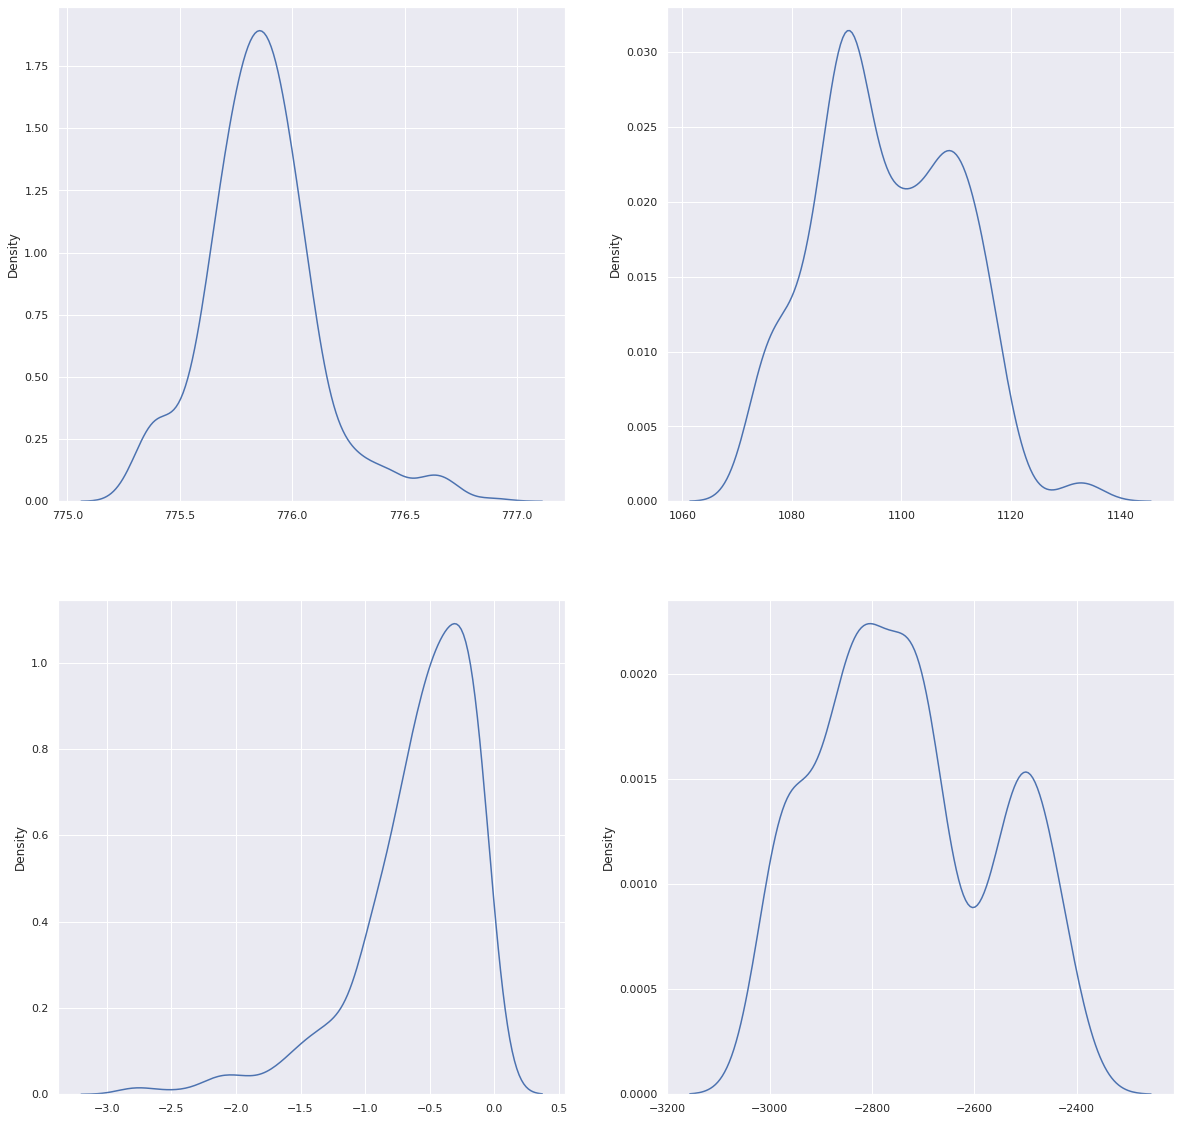

In [32]:
import seaborn 
import matplotlib.pyplot as pyplot
seaborn.set()

results = mcmc.get_samples()
fig, axes = pyplot.subplots(2, 2, figsize=(20, 20))
for index, variable in enumerate(results):
    axis = axes[index % 2][index // 2]
    seaborn.kdeplot(results[index], ax=axis)